In [136]:
using LinearAlgebra
using FFTW
using Plots
using BenchmarkTools
using OrdinaryDiffEq

include("../../code/TaylorFourier.jl");



# The main problem of artificial satellite theory (in Stiefel-Scheifele VOP formulation)

Written as a system of ODEs for a fictitious time $\tau$ (with the physical time $t$ as an additional state variable):

\begin{equation}
\begin{split}
\frac{d}{d\tau} q &= r \, v, \quad q(0) = q_0,\\
\frac{d}{d\tau} v &= -\frac{\mu}{r^2} q -  r\, \nabla V(q), \quad v(0)=v_0\\
\frac{d}{d\tau} t &= r, \quad t(0) = t_0
\end{split}
\tag{1}
\end{equation}

where 

\begin{equation}
q_0 = \left(
\begin{matrix}
x_0\\
y_0\\
z_0
\end{matrix}
\right), \quad 
v_0 = \left(
\begin{matrix}
\dot x_0\\
\dot y_0\\
\dot z_0
\end{matrix}
\right), \quad r=\|q\|, 
%\quad h = \frac{1}{2} \langle v, v \rangle - \frac{\mu}{r} + V(q)
\end{equation}

and

\begin{equation}
V(q) =  \frac{C}{2\, r^3} \,\left(3\, \sin^2\theta -1 \right), \quad \sin\theta = \frac{z}{r}, \quad C=J_2\, \mu\, R_e^2.
\end{equation}

Constant parameters of the problem: $R_e = 6378.135 km$, $\mu=398600km^3/s^2$, $J_2=0.0010826157$.


The energy $\mathcal{E}(q,v):= \frac12 \, \langle v, v \rangle - \frac{\mu}{r} + V(q)$ is an invariant of the equations of motion. 
In addition, the $z$-component of the angular momentum
\begin{equation*}
x\, \dot y - \dot x\, y
\end{equation*}
is also a first integral.

In [137]:
function Energy(q,v,parms)
    μ = parms[1]
    C = parms[2]
    return 0.5*dot(v,v) - μ/norm(q)  +  V(q,parms)
end

function V(q,parms) 
    C = parms[2]
    z = q[3]
    r = norm(q)    
    sinth = z/r
    return C*(3*sinth^2-1)/(2*r^3)
end

function ZAngularMomentum(q,v) 
    return q[1]*v[2] - q[2]*v[1]
end

ZAngularMomentum (generic function with 1 method)

Following~\cite{Stiefel-Scheifele1971}, $q(\tau)$ and $t(\tau)$ in (1) can be obtained as follows: 

\begin{align*}
q(\tau) &= L(u(\tau))u(\tau), \quad v(\tau) = \frac{2}{\|u(\tau)\|^2}\, L(u(\tau)) u'(\tau), \\
\quad 
u(\tau) &=  \cos(\omega \tau) \alpha(\tau)+ \omega^{-1} \sin(\omega \tau) \beta(\tau), \quad
u'(\tau) =  -\omega\, \sin(\omega \tau) \alpha(\tau)+ \cos(\omega \tau) \beta(\tau),
\end{align*}

where

\begin{equation*}
\omega = \sqrt{-\frac12\, \mathcal{E}(q_0,v_0)}, \qquad
L({\bf u}) =
\left(
\begin{matrix}
u_1 & -u_2 & -u_3 & u_4 \\
u_2 & u_1 & -u_4 & -u_3 \\
u_3 & u_4 & u_1 & u_2 \\
%u_4 & -u_3 & u_2 & -u_1
\end{matrix}
\right),
\end{equation*}

and $(\alpha(\tau),\beta(\tau),t(\tau))$ is the solution of the 8-dimensional ODE system

\begin{equation}
\begin{split}
\frac{d}{d\tau}\alpha &=  \omega^{-1} \sin(\omega \tau) \nabla R( \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta),  \quad \alpha(0)=u_0,\\
\frac{d}{d\tau} \beta &= -\cos(\omega \tau)  \nabla R( \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta), \quad \beta(0)=w_0,\\
\frac{d}{d\tau} t &= \| \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta\|^2, \quad t(0) = t_0.
\end{split}
\tag{2}
\end{equation}


Here, $R(u) = \frac14\,  \|u\|^2\, V(L(u) u)$, that is,

\begin{equation*}
R(u) = \frac{1}{8\, r^2} \,\left(3\, (\sin(\theta))^2 -1 \right),
\end{equation*}

where  $r = u_1^2+u_2^2+u_3^2+u_4^2$ and
$\sin(\theta) = 2\,(u_1 u_3 + u_2 u_4)/r$. As for the vectors $u_0, w_0 \in \mathbb{R}^2$,

- $u_0 \in \mathbb{R}^4$ is chosen in such a way that 
\begin{equation*}
q_0 = L(u_0) u_0, 
\end{equation*}

- $w_0\in \mathbb{R}^4$ is determined as 
\begin{equation*}
w_0 = \frac12\, L(u_0)^T \, \dot q_0.
\end{equation*}

Obviously, there are infinitely many vectors $u_0$ that satisfy $q_0 = L(u_0) u_0$. The function $\chi(q)$ implemented below computes one of them. 

In [138]:
function χ(q)
    x = q[1]
    y = q[2]
    z = q[3]
    r = sqrt(x^2+y^2+z^2)
    if x >= 0
        aux = r + x
        u1 = 0.5*sqrt(aux)
        u4 = u1
        u2 = (y*u1 + z*u4)/aux
        u3 = (z*u1 - y*u4)/aux
    else
        aux = r - x
        u2 = 0.5*sqrt(aux)
        u3 = u2
        u1 = (y*u2 + z*u3)/aux
        u4 = (z*u2 - y*u3)/aux
    end
    return [u1, u2, u3, u4]
end

L(u) = [u[1] -u[2] -u[3]  u[4]
     u[2]  u[1] -u[4] -u[3]
     u[3]  u[4]  u[1]  u[2] ];

In [139]:
function qfromU(U, τ, parms)
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)
    α = U[1:4]
    β = U[5:8]
    u = c * α + (s/ω) * β
    q = L(u)*u
    return q
end


function vfromU(U, τ, parms)
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)
    α = U[1:4]
    β = U[5:8]
    u = c * α + (s/ω) * β
    r = dot(u,u)
    w = -ω * s * α + c * β
    v = 2/r*L(u)*w
    return v
end

vfromU (generic function with 1 method)

Let us check it for a randomly chosen $q_0$:

In [140]:
q0 = rand(3)
u0 = χ(q0)
norm(q0 - L(u0)*u0)

5.551115123125783e-17

In [141]:
v0 = rand(3)
w0 = 0.5*(L(u0)')*v0
norm(2/dot(u0,u0)*L(u0)*w0 - v0)

1.2412670766236366e-16

## Numerical solution with 9th order explicit RK method (Vern9)

We next implement in an efficient way the system of ODEs defined in (2).

In [142]:

function fODE!(dU, U, parms, τ) 
    # Efficient implementation of  the differential equations for (α, β, t)
    # α = U[1:4],  dα/dτ = dU[1:4]
    # β = U[5:8],  dβ/dτ = dU[5:8]
    # t = U[9],    dt/dτ = dU[9]
    C = parms[2]
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)/ω
    #u = c * α + s * β
    u1 = c * U[1] + s * U[5]
    u2 = c * U[2] + s * U[6]
    u3 = c * U[3] + s * U[7]
    u4 = c * U[4] + s * U[8]
    z = 2*(u1*u3 + u2*u4)
    r = u1^2 + u2^2 + u3^2 + u4^2
    w = 1/r^3
    sth = z/r
    A = 0.5*C*w*(1 - 6*sth^2)
    B = 1.5*C*w*sth
    gradR1 = A*u1+B*u3
    gradR2 = A*u2+B*u4
    gradR3 = A*u3+B*u1
    gradR4 = A*u4+B*u2
    dU[1] = s*gradR1
    dU[2] = s*gradR2
    dU[3] = s*gradR3
    dU[4] = s*gradR4
    dU[5] = -c*gradR1
    dU[6] = -c*gradR2
    dU[7] = -c*gradR3
    dU[8] = -c*gradR4
    dU[9] = r
    return nothing
end

fODE! (generic function with 1 method)

## Geostationary orbit

We now consider the initial state of a Geostationary satellite (Montenbruck 2000, pg. 116) and solve (2) numerically with an explicit RK method of order 9 due to Verner.

In [143]:
μ = 398600.8
R_e = 6378.135
ϵ = 0.0010826157
C = μ * R_e^2 * ϵ
#q0 = [0., 37947.73745727695, 0.]
#v0 = [3.297676220718193,0., 0.8244190551795483]
# Geostationary satellite (Montenbruck pg. 116)
q0 = [4.21491336e4,0.0,0.0]                            # km
v0 = [0.0, 3.075823259987749,0.0010736649055318406 ]   # km/s


ω = sqrt(-Energy(q0,v0,[μ,C])/2)

u0 = χ(q0)
w0 = 0.5*(L(u0)') * v0

α0  = u0
β0  = w0
orbit_period = 2*π/ω

t0 = 0.
n_orbits = 400
tspan = (t0,t0+n_orbits*orbit_period)
U0 = [α0; β0; t0]

parms = [μ,C,ω]

prob = ODEProblem(fODE!, U0, tspan, parms);


M = 8
times = range(tspan[1],tspan[2],length=Int64(n_orbits*2M)+1)

tol = 1e-13
@time sol = solve(prob, Vern9(), abstol=tol, reltol=tol,saveat=times);

  0.181037 seconds (478.39 k allocations: 28.302 MiB, 37.52% gc time, 53.73% compilation time: 100% of which was recompilation)


In [144]:
orbit_period

4.087110716109999

In [145]:
E0 = Energy(q0,v0,parms)

-4.72668790298803

Let us check the errors in the conservarion of energy and the z component of the angular momemtum.

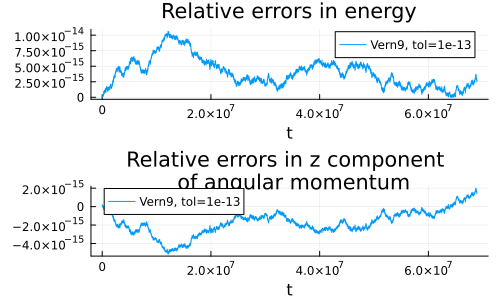

In [146]:
E0 = Energy(q0,v0,parms)
qq = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol.u, sol.t)
vv = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol.u, sol.t)
tt = [U[9] for U in sol.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq, vv)



pl1 = plot(title="Relative errors in energy", xlabel="t")
plot!(pl1, tt, Eerrs,label="Vern9, tol=1e-13")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq, vv)

pl2 = plot(title="Relative errors in z component \n of angular momentum", xlabel="t")
plot!(pl2, tt, Aerrs,label="Vern9, tol=1e-13")

plot(pl1,pl2, layout=(2,1), size=(500,300))

### Global errors in positions ($q$) and physical time ($t$)

In order to estimate the global errors in $q$ and $t$ of the numerical solution obtained above, we will compute a new numerical approximation with high precision: tol=1e-20, and higher precision arithmetic (BigFloat).

In [147]:
prob_BF = ODEProblem(fODE!, BigFloat.(U0), BigFloat.(tspan), BigFloat.(parms));

@time sol_ex = solve(prob_BF, Vern9(), abstol=1e-20, reltol=1e-20,saveat=times);

 19.840950 seconds (411.47 M allocations: 18.260 GiB, 10.00% gc time, 4.99% compilation time: 100% of which was recompilation)


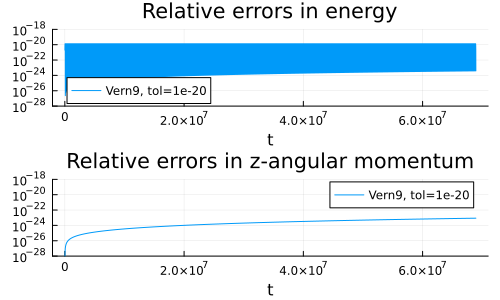

In [148]:
qq_ex = map((U,τ) -> qfromU(U,τ,parms), sol_ex.u, sol_ex.t)
vv_ex = map((U,τ) -> vfromU(U,τ,parms), sol_ex.u, sol_ex.t)
tt_ex = [U[9] for U in sol_ex.u]
EE_ex = map((q,v) -> abs(Energy(q,v,parms)), qq_ex, vv_ex)
Eerrs_ex = abs.(EE_ex ./ EE_ex[1] .- 1)   
AA_ex = map((q,v) -> abs(ZAngularMomentum(q,v)), qq_ex, vv_ex)
Aerrs_ex = abs.(AA_ex ./ AA_ex[1] .- 1) 


pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl1, tt_ex,Eerrs_ex,label="Vern9, tol=1e-20", legend=:bottomleft)


pl2 = plot(title="Relative errors in z-angular momentum", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl2, tt_ex,Aerrs_ex,label="Vern9, tol=1e-20")

plot(pl1,pl2, layout=(2,1), size=(500,300))

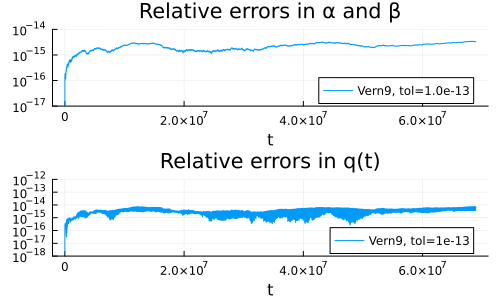

In [149]:
errors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol.u, sol_ex.u) .+ eps(0.01)

pl1 = plot(tt_ex, errors, title="Relative errors in α and β", label="Vern9, tol=$tol", 
    yscale=:log10, ylims=(1e-17,1e-14),xlabel="t", legend=:bottomright);

qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)
pl2 = plot(title="Relative errors in q(t)", xlabel="t", 
           yscale=:log10, ylims=(1e-18,1e-12),legend=false)
plot!(pl2, tt_ex, qerrs,  label="Vern9, tol=1e-13", legend=:bottomright)

plot(pl1, pl2, layout = (2,1), size=(500,300))

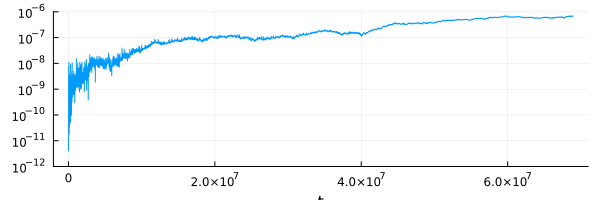

In [150]:
terrs = norm.(tt-tt_ex) 
pl_time_RK = plot(xlabel="t")#, title="Absolute errors in physical time")
plot!(pl_time_RK, tt_ex[2:end], abs.(terrs[2:end]),  label="Vern9, tol=1e-13", 
     yscale=:log10, ylims=(1e-12,1e-6),legend=false, size=(600,200))

## Taylor-Fourier integration

We next integrate the problem above with our Taylor-Fourier integrator

In [151]:
include("J2_VOP_ODE_TF.jl")  # include the functions that define the ODE as required by 
                             # our TaylorFourier integrator

J2_VOP_cache_init (generic function with 1 method)

In [152]:
deg = 8
tf_cache = J2_VOP_cache_init(U0,parms,ω,deg,M)
prob_TF = PeriodicODEProblem(TF_ODE!, tf_cache, U0, ω)
sol_TF = TaylorFourierSolve(prob_TF,deg,M,n_orbits);

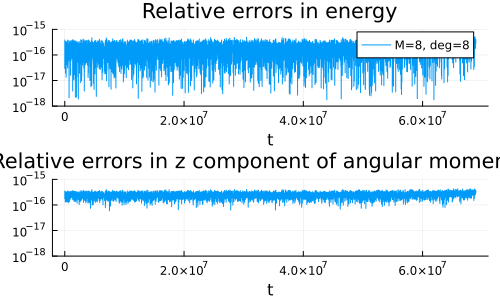

In [153]:
E0 = Energy(q0,v0,parms)
qq_TF = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
vv_TF = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
tt_TF = [U[9] for U in sol_TF.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF, vv_TF) .+ eps(0.01)



pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-18,1e-15))
plot!(pl1, tt_TF, Eerrs,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq_TF, vv_TF) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-15),legend=false)
plot!(pl2, tt_TF, Aerrs,label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

In [154]:
savefig(pl1, "error_energy.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/error_energy.pdf"

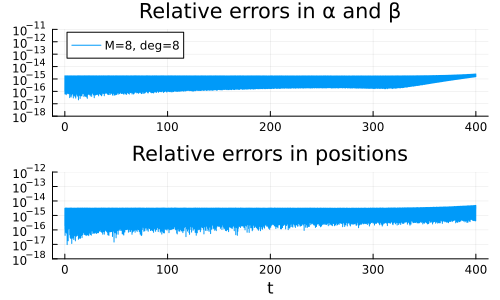

In [155]:
aberrors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol_TF.u, sol_ex.u)

pl1 = plot(sol_ex.t/orbit_period, aberrors, title="Relative errors in α and β", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-11), legend=:topleft);

qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(title="Relative errors in positions", xlabel="t", yscale=:log10, 
    ylims=(1e-18,1e-12), legend=false)
plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

plot(pl1, pl2, layout = (2,1), size=(500,300))

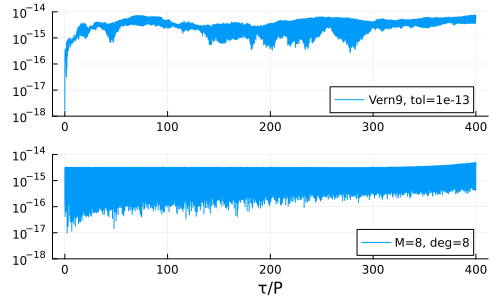

In [156]:



qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="Vern9, tol=1e-13")



qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)

plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

pl_pos = plot(pl1, pl2, layout = (2,1), size=(500,300))

In [157]:
savefig(pl_pos, "position_errors.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/position_errors.pdf"

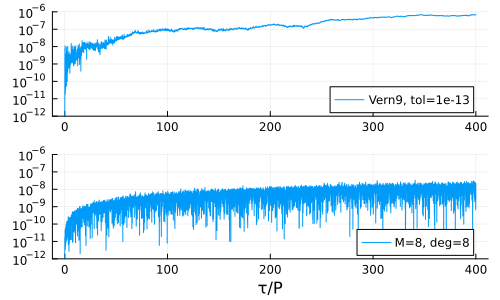

In [158]:
terrs = norm.(tt-tt_ex) .+ eps(0.01)
pl1 = plot(yscale=:log10, ylims=(1e-12,1e-6), legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, terrs,  label="Vern9, tol=1e-13")

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(xlabel="τ/P",
               yscale=:log10, ylims=(1e-12,1e-6), legend=:bottomright)
plot!(pl2, sol_ex.t/orbit_period, terrs,  label="M=$M, deg=$deg")

pl_time = plot(pl1,pl2, layout=(2,1), size=(500,300))

In [159]:
savefig(pl_time, "time_errors.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/time_errors.pdf"

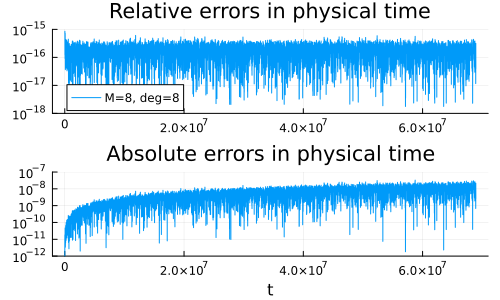

In [160]:
t_rel_errs =  abs.(tt_TF-tt_ex) ./ abs.(tt_ex) .+ eps(0.01)
pl1 = plot(tt_ex, t_rel_errs, title="Relative errors in physical time",  
          label="M=$M, deg=$deg", 
              yscale=:log10, ylims=(1e-18,1e-15), legend=:bottomleft);

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(title="Absolute errors in physical time", xlabel="t",
               yscale=:log10, ylims=(1e-12,1e-7), legend=:false)
plot!(pl2, tt_ex, terrs,  label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

In [161]:
@btime solve(prob, Vern9(), abstol=1e-13, reltol=1e-13,saveat=times)
@btime TaylorFourierSolve(prob_TF,deg,M,n_orbits);

  15.381 ms (75741 allocations: 9.51 MiB)
  580.583 μs (6852 allocations: 1.05 MiB)


In this example, our TaylorFourier integrator gives more precision with 35 times less CPU time.

In [162]:
18/2.579

6.979449398991857

## Highly eccentric orbit

### Numerical solution with 9th order explicit RK method (Vern9)

We now consider the initial state of a satellite with a highly eccentric orbit (Montenbruck 2000, pg. 51) and solve (2) numerically with an explicit RK method of order 9 due to Verner.

In [163]:
μ = 398600.8
R_e = 6378.135
ϵ = 0.0010826157
C = μ * R_e^2 * ϵ

# Highly eccentric orbit (Montenbruck pg. 51)

q0=[1.1959886901183693e7,-1.6289448826603336e7,-5.963757695165331e6]/1000
v0=[4724.300951633136,-1109.9935305609756,-384.7854410416176]/1000     



ω = sqrt(-Energy(q0,v0,[μ,C])/2)

u0 = χ(q0)
w0 = 0.5*(L(u0)') * v0

α0  = u0
β0  = w0
orbit_period = 2*π/ω

t0 = 0.
n_orbits = 40
tspan = (t0,t0+n_orbits*orbit_period)
U0 = [α0; β0; t0]

parms = [μ,C,ω]

prob = ODEProblem(fODE!, U0, tspan, parms);


M = 128
times = range(tspan[1],tspan[2],length=Int64(n_orbits*2M)+1)

tol = 1e-14
@time sol = solve(prob, Vern9(), abstol=tol, reltol=tol,saveat=times);

  0.011024 seconds (49.44 k allocations: 6.587 MiB)


Let us check the errors in the conservarion of energy and the z component of the angular momemtum.

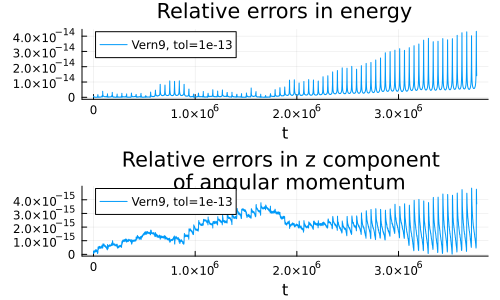

In [164]:
E0 = Energy(q0,v0,parms)
qq = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol.u, sol.t)
vv = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol.u, sol.t)
tt = [U[9] for U in sol.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq, vv)



pl1 = plot(title="Relative errors in energy", xlabel="t")
plot!(pl1, tt, Eerrs,label="Vern9, tol=1e-13")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq, vv)

pl2 = plot(title="Relative errors in z component \n of angular momentum", xlabel="t")
plot!(pl2, tt, Aerrs,label="Vern9, tol=1e-13")

plot(pl1,pl2, layout=(2,1), size=(500,300))

### Global errors in positions ($q$) and physical time ($t$)

In order to estimate the global errors in q adn t of the numerical solution obtained above, we will compute a new numerical approximation with high precision: tol=1e-20, and higher precision arithmetic (BigFloat).

In [165]:
prob_BF = ODEProblem(fODE!, BigFloat.(U0), BigFloat.(tspan), BigFloat.(parms));

@time sol_ex = solve(prob_BF, Vern9(), abstol=1e-20, reltol=1e-20,saveat=times);

  9.308372 seconds (217.16 M allocations: 9.791 GiB, 9.08% gc time)


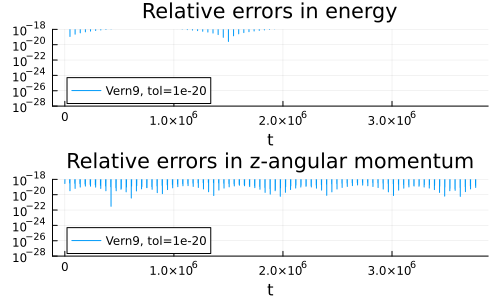

In [166]:
qq_ex = map((U,τ) -> qfromU(U,τ,parms), sol_ex.u, sol_ex.t)
vv_ex = map((U,τ) -> vfromU(U,τ,parms), sol_ex.u, sol_ex.t)
tt_ex = [U[9] for U in sol_ex.u]
EE_ex = map((q,v) -> abs(Energy(q,v,parms)), qq_ex, vv_ex)
Eerrs_ex = abs.(EE_ex ./ EE_ex[1] .- 1)   
AA_ex = map((q,v) -> abs(ZAngularMomentum(q,v)), qq_ex, vv_ex)
Aerrs_ex = abs.(AA_ex ./ AA_ex[1] .- 1) 


pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl1, tt_ex,Eerrs_ex,label="Vern9, tol=1e-20", legend=:bottomleft)


pl2 = plot(title="Relative errors in z-angular momentum", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl2, tt_ex,Aerrs_ex,label="Vern9, tol=1e-20")

plot(pl1,pl2, layout=(2,1), size=(500,300))

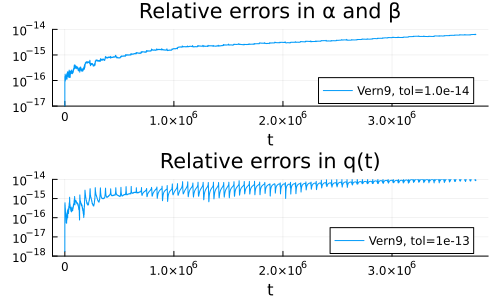

In [167]:
errors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol.u, sol_ex.u) .+ eps(0.01)

pl1 = plot(tt_ex, errors, title="Relative errors in α and β", label="Vern9, tol=$tol", 
    yscale=:log10, ylims=(1e-17,1e-14),xlabel="t", legend=:bottomright);

qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)
pl2 = plot(title="Relative errors in q(t)", xlabel="t", 
           yscale=:log10, ylims=(1e-18,1e-14),legend=false)
plot!(pl2, tt_ex, qerrs,  label="Vern9, tol=1e-13", legend=:bottomright)

plot(pl1, pl2, layout = (2,1), size=(500,300))

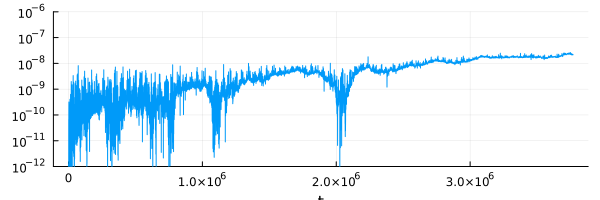

In [168]:
terrs = norm.(tt-tt_ex) 
pl_time_RK = plot(xlabel="t")#, title="Absolute errors in physical time")
plot!(pl_time_RK, tt_ex[2:end], abs.(terrs[2:end]),  label="Vern9, tol=1e-13", 
     yscale=:log10, ylims=(1e-12,1e-6),legend=false, size=(600,200))

## Taylor-Fourier integration

We next integrate the problem above with our Taylor-Fourier integrator

In [169]:
include("J2_VOP_ODE_TF.jl")  # include the functions that define the ODE as required by 
                             # our TaylorFourier integrator

J2_VOP_cache_init (generic function with 1 method)

In [170]:
deg = 14
tf_cache = J2_VOP_cache_init(U0,parms,ω,deg,M)
prob_TF = PeriodicODEProblem(TF_ODE!, tf_cache, U0, ω)
sol_TF = TaylorFourierSolve(prob_TF,deg,M,n_orbits);

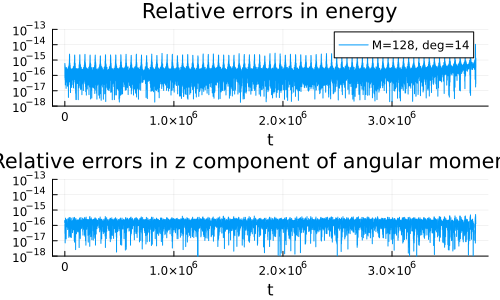

GKS: Number of points is invalid in routine POLYLINE


In [171]:
E0 = Energy(q0,v0,parms)
qq_TF = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
vv_TF = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
tt_TF = [U[9] for U in sol_TF.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF, vv_TF) .+ eps(0.01)



pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-18,1e-13))
plot!(pl1, tt_TF, Eerrs,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq_TF, vv_TF) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-13),legend=false)
plot!(pl2, tt_TF, Aerrs,label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

In [172]:
savefig(pl1, "error_energy.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/error_energy.pdf"

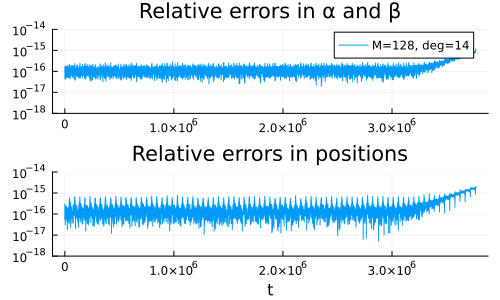

In [173]:
aberrors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol_TF.u, sol_ex.u)

pl1 = plot(tt_ex, aberrors, title="Relative errors in α and β", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-14));

qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(title="Relative errors in positions", xlabel="t", yscale=:log10, ylims=(1e-18,1e-14), legend=false)
plot!(pl2, tt_ex, qerrs,  label="M=$M, deg=$deg")

plot(pl1, pl2, layout = (2,1), size=(500,300))

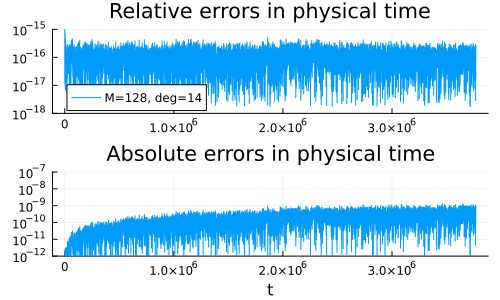

In [174]:
t_rel_errs =  abs.(tt_TF-tt_ex) ./ abs.(tt_ex) .+ eps(0.01)
pl1 = plot(tt_ex, t_rel_errs, title="Relative errors in physical time",  label="M=$M, deg=$deg", 
              yscale=:log10, ylims=(1e-18,1e-15), legend=:bottomleft);

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(title="Absolute errors in physical time", xlabel="t",
               yscale=:log10, ylims=(1e-12,1e-7), legend=:false)
plot!(pl2, tt_ex, terrs,  label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

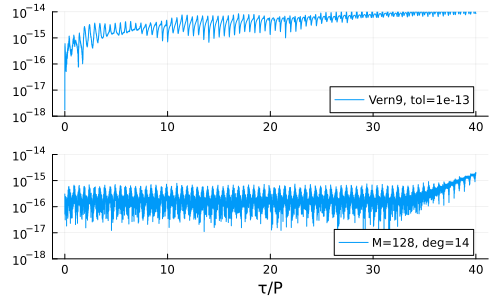

In [175]:



qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="Vern9, tol=1e-13")



qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)

plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

pl_pos = plot(pl1, pl2, layout = (2,1), size=(500,300))

In [176]:
savefig(pl_pos, "position_errors_ecc.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/position_errors_ecc.pdf"

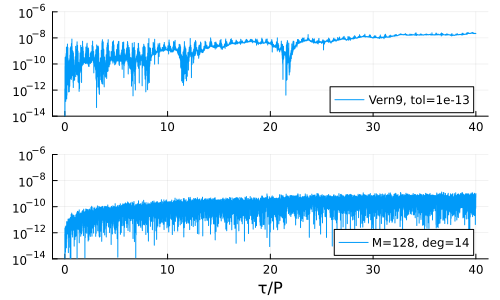

In [177]:
terrs = norm.(tt-tt_ex) .+ eps(0.01)
pl1 = plot(yscale=:log10, ylims=(1e-14,1e-6), legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, terrs,  label="Vern9, tol=1e-13")

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(xlabel="τ/P",
               yscale=:log10, ylims=(1e-14,1e-6), legend=:bottomright)
plot!(pl2, sol_ex.t/orbit_period, terrs,  label="M=$M, deg=$deg")

pl_time = plot(pl1,pl2, layout=(2,1), size=(500,300))

In [178]:
savefig(pl_time, "time_errors_ecc.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/time_errors_ecc.pdf"

In [179]:
@time solve(prob, Vern9(), abstol=1e-13, reltol=1e-13,saveat=times)
@time TaylorFourierSolve(prob_TF,deg,M,n_orbits);

  0.008664 seconds (41.09 k allocations: 5.568 MiB)
  0.004696 seconds (11.05 k allocations: 6.479 MiB)


In [180]:
0.015659/0.007889

1.9849157054125997

In this example, our TaylorFourier integrator gives more precision with 2.6 times less CPU time.